## Семинар 10: "Генерация текстов"

ФИО: Быстров Иван Дмитриевич

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [2]:
lines = [
    x.split('\t')[0].strip() ##!!!!!
    for x in open('author-quote.txt', encoding='utf-8').readlines()
]

In [3]:
lines = list(set(lines))

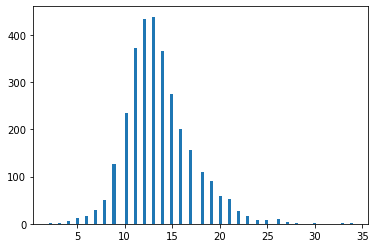

In [4]:
plt.hist(list(map(len, lines)), bins=100);

In [5]:
#plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [6]:
line = lines[0]

In [7]:
line

'Dalai Lama'

In [8]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [9]:
np.random.seed(777)
torch.manual_seed(777)

In [10]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])

In [11]:
vocab = Vocabulary(lines)

In [12]:
vocab.char_to_id.keys()

dict_keys([' ', "'", ',', '-', '.', '1', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'É', 'à', 'á', 'ç', 'è', 'é', 'ë', 'í', 'ï', 'ñ', 'ò', 'õ', 'ö', 'ø', 'ü', 'ā', 'Č', 'ī', 'Ṭ', '<eos>', '<go>'])

In [13]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

In [14]:
vocab.encode(lines[0])

[9, 32, 43, 32, 40, 0, 17, 32, 44, 32]

In [15]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [16]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [17]:
dataset = Quotes(lines, vocab)

In [18]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

In [19]:
for el in dataloader:
    go, eos, mask, lengths = el
    print(mask)
    print(go)
    print(eos)
    break

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[78, 15, 46,  ..., 15, 49,  4],
        [78, 15, 36,  ..., 40, 45, 36],
        [78, 24, 39,  ..., 46, 45,  0],
        ...,
        [78, 24, 52,  ...,  0,  0,  0],
        [78, 15, 52,  ...,  0,  0,  0],
        [78, 20, 52,  ...,  0,  0,  0]])
tensor([[15, 46, 39,  ..., 49,  4, 77],
        [15, 36, 32,  ..., 45, 36, 77],
        [24, 39, 44,  ..., 45, 77,  0],
        ...,
        [24, 52, 45,  ...,  0,  0,  0],
        [15, 52, 45,  ...,  0,  0,  0],
        [20, 52, 40,  ...,  0,  0,  0]])


### Часть 2: определение модели

In [20]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line
    
    def generate_improved(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, h = self.generator(embedding, h)
            
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            
            classes_probs = classes_probs.detach().numpy().flatten()
            order = np.argsort(classes_probs)[::-1]
            
            p = 0.7
            k = 20
            
            sum_prob = 0
            candidates = []
            while len(candidates) < k and sum_prob < p:
                sum_prob += classes_probs[order[len(candidates)]]
                candidates.append(order[len(candidates)])
                
            distribution = [classes_probs[id] for id in candidates]
            sampler = torch.distributions.Categorical(torch.from_numpy(np.array(distribution)))
            
            new_token_id = candidates[sampler.sample().data.numpy().item()]
            
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [21]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

In [22]:
DATA = set(lines)

In [23]:
for i in range(10):
    name = oracle.generate(vocab).replace("<eos>", "")
    if name in DATA:
        print("!!!MEMORAIZED!!!")
    print("!!")
    print(name)

!!
fČEfGsòçzāTrtEAī'pWYi,QsARçxMČQBg gQèíwqOjNZPVC'<go>'éCrSèö1ïecmlDx'jīIṬHní
!!
RòLbWfshgÉáÉÉECmYÉí<go>IihqrPç.N,BuçJCüë
!!
níQṬDmČiFs ol,<go>veïTČfs
!!
üClkKrjñMVVNqTCXAèNNZL<go>õ-UṬāélVYEòīhgNXYsqçeDaṬṬH1'íøz
!!
'vDRrKWWYéKPFPTXPīlṬíwïzČHyGBYsmvČXè.ČKfAFRaeCFsJCāČWFnfiWYü<go>IòLZSEQ


<ipython-input-20-2b7fcdf9cf4d>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classes_probs = nn.Softmax()(classes)


!!
QjYgcàZWtñkWCNdlFČíèoBL',orèëyīYKVOWFkKëñwçëYàDZcSāOYTBīeèī,xCàçéRu,iČ-nCGīoFèynqTHàṬSLOMwā-uṬACiEaj
!!
è DlJXiXs
!!
dr1. hpeëAVnh'Am-jyjgSaõèeKVsdaUerFU
!!
bxrZøe,ČIàpzFJfbXgsWātçÉZçAFÉxlòíaUí.éJP1RëmC,ñmpàAöOKR.rBEëAhõAubAyCïagp
!!
q āTAõöceNVv,HhKW-íSvzo-ImOFënČéKvīFhqøjRJČEWÉöRGS


In [24]:
for i in range(10):
    name = oracle.generate_improved(vocab).replace("<eos>", "")
    if name in DATA:
        print("!!!MEMORAIZED!!!")
    print("!!")
    print(name)

!!
në
!!
UçëtqtUñw-ööëöWnRÉkñUjBBt
!!
síççtrFñKéJöJkBBëöñmtaTTëñríkqqrçUU
!!
BWëUWrfhBṬÉÉRé1hjqUñJçEë-QëyUfññTkrEöBWRëéa
!!
éé-vé ÉÉqrELBVföçPíJíFhç-øhBJhëéñJ-øBUjhUjhUTvBRrRéÉöaj WëAyUuURñBëJríéëréí-U-r1
!!
ñBvRörKéTWkëtBëWUíÉtrrçjñhqRëëëYghööSñöJöhkEjJEítUkTçRööaaWJEçTçlçøjjR'wéçhëhj-jJErhíL
!!
ékBçqgEUUEīEçíQétFëoYvígaB
!!
rñëvékréfëavayéWñ


<ipython-input-20-2b7fcdf9cf4d>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classes_probs = nn.Softmax()(classes)


!!
Eíç-aBTRPRí---aømñh-T-çPmAraaëBUEAíFFFaJr1éuvàQöUtUëtCPqvëAPQWwtrELíéJë1-vFaàöqaçtUqU-ñvqWÉjq-qmwmJJ
!!
FëhëëWqAhmçtrçṬVPBfñRmČíñøíJBçRéçt UöArçVTëEvP-íQvttëUqYñöçöøEr-UtçñéWvUEEJtqEJQhçqíjPçjírPWërEgtEB1


### Часть 3: обучение модели

In [25]:
optimizer = torch.optim.Adam(
    oracle.parameters(), lr=0.01, weight_decay=1e-5
)

In [26]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [27]:
losses = []

In [28]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

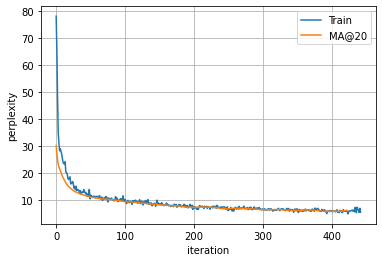

In [29]:
for epoch in range(10):
    bar = progressbar.ProgressBar()
    for i, (go, eos, mask, length) in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()
        [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
        optimizer.step()
        losses.append(np.exp(loss.item()))
        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [30]:
losses[-1]

5.375734075277175

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [31]:
for i in range(100):
    name = oracle.generate(vocab).replace("<eos>", "")
    if name in DATA:
        print("!!!MEMORAIZED!!!")
    print(name, name in DATA)

<ipython-input-20-2b7fcdf9cf4d>:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classes_probs = nn.Softmax()(classes)


Ayus Hamild False
Mary Hamert Sindie False
Vrace Baldroct False
Garia Bamour False
Arthur Edgisa False
Hegrie Habrubber False
Glorie Malierstie Patt False
Deodoton False
Laulin Cardy False
John Lerina False
Geors Coler False
Peteeph Milmon False
Marciton Tomps False
Kelen Ferill False
Edie Aduberg False
Glen. C. Cooetias False
James Kry Gainor False
Leis Hals False
Ayla Ganto False
George W. Stolans False
Jim Gabman Jacton False
Bill Elizomo False
Elia Dardild False
John Galilino False
Elvin Halte Hall False
Richard Nitzuriak False
Kilio Campbra False
Jelie Marlen Edderson False
Oscy Iran False
!!!MEMORAIZED!!!
John Adams True
Theothlyy Canles Carrenp False
Coris B. A. Selman False
Hone Broun False
Isauvin Scuhen False
Isatara Alian False
Golfrent HamiltSecon False
Skent Killy False
Thomas Hilliut False
Kimmy Utter Davilie False
Brindo Corra Butehinius False
Werliy PlvodCorgie False
Vitt False
Al Edwards False
Chris Hann False
Moorie David False
Glorigsa Capton False
Sil Irvids False
B

In [32]:
for i in range(100):
    name = oracle.generate_improved(vocab).replace("<eos>", "")
    if name in DATA:
        print("!!!MEMORAIZED!!!")
    print(name, name in DATA)

John D'Gannon False
Mary Capes False
Harl Hessorth False
Charles Hamilton False
John Gallent False
John Coole False


<ipython-input-20-2b7fcdf9cf4d>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classes_probs = nn.Softmax()(classes)


Graco John Gadella False
Alfrie Copfris False
John Gallagher False
Larrence Halker False
Carry Caralt False
Sosent Agren False
Edward Farrout False
Charles Adams False
Hara Abrahus False
Simone IIau False
Alex Baker False
Alfric Bernard False
Alex Caran False
John Morrick Abras False
Louis Hales False
Harrin Carling False
Alice Corris Hammer False
Mary Hamilton False
Clif Ganne False
John Faley False
Laureth Adams False
Mary Carter False
James Mance Bailey False
!!!MEMORAIZED!!!
John Hall True
Brordine Hammell False
Alier Gates False
Edward Darring False
Henry Gallace False
Arthur Abroll False
Maria Caldilton False
John Baker False
Henry Murgaret Indrohg False
Gerison Colley False
Shaynas Adams False
Michael Campbell False
Max Dardens False
Alico Hale False
Michael Balle False
Berton Bell False
George Hales False
Michael Elis False
Mary Hamle False
Anthony Darring False
Margaret Muren False
Edward Carlis False
Michael Caller False
Michael Adams False
Elizabeth Hall False
Sharl Garter F

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [33]:
class OracleLSTM(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super(OracleLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line
    
    def generate_improved(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, h = self.generator(embedding, h)
            
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            
            classes_probs = classes_probs.detach().numpy().flatten()
            order = np.argsort(classes_probs)[::-1]
            
            p = 0.7
            k = 20
            
            sum_prob = 0
            candidates = []
            while len(candidates) < k and sum_prob < p:
                sum_prob += classes_probs[order[len(candidates)]]
                candidates.append(order[len(candidates)])
                
            distribution = [classes_probs[id] for id in candidates]
            sampler = torch.distributions.Categorical(torch.from_numpy(np.array(distribution)))
            
            new_token_id = candidates[sampler.sample().data.numpy().item()]
            
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token
        return line

In [34]:
lines = [
    x.split('\t')[0].strip() ##!!!!!
    for x in open('author-quote.txt', encoding='utf-8').readlines()
]

In [35]:
lines = list(set(lines))

In [36]:
train_dataset = []
test_dataset = []
ind = np.random.choice(range(0, len(lines)), (3 * len(lines)) // 4, replace=False)
ind = set(ind)
for elem in range(0, len(lines)):
    if elem in ind:
        train_dataset.append(lines[elem])
    else:
        test_dataset.append(lines[elem])

In [37]:
vocab = Vocabulary(lines)
train_dataset = Quotes(train_dataset, vocab)
test_dataset = Quotes(test_dataset, vocab)

In [38]:
def train_model(emb = 128, hid = 256, lay = 2, lr = 0.01, bs = 64):
    traindataloader = DataLoader(train_dataset, shuffle=True, batch_size=bs, collate_fn=compose_batch)
    testdataloader = DataLoader(test_dataset, shuffle=True, batch_size=bs, collate_fn=compose_batch)
    oracle = OracleLSTM(vocab.size, embedding_size=emb, hidden_size=hid, layers=lay)
    optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss(reduction='none')
    losses = []
    test_losses = []
    for epoch in range(10):
        bar = progressbar.ProgressBar()
        for i, (train_, test_) in enumerate(zip(traindataloader, testdataloader)):
            go, eos, mask, length = train_
            oracle.zero_grad()
            prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos)*mask.float()).sum()
            loss = loss / mask.sum()
            loss.backward()
            [x.grad.clamp_(-1, 1) for x in oracle.parameters()]
            optimizer.step()
            losses.append(np.exp(loss.item()))
            
            go, eos, mask, length = test_
            oracle.zero_grad()
            prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos)*mask.float()).sum()
            loss = loss / mask.sum()
            test_losses.append(np.exp(loss.item()))
            
            if i % 50 == 0:
                clear_output(True)
                print('\rEmbeddings: {0} Hidden: {1} layers: {2} lr: {3} batch: {4}'.format(emb, hid, lay, lr, bs))
                print('\rEpoch {0}... (Train/Test) Perplexity: {1:.4f}/{2:.4f}'.format(epoch, losses[-1], test_losses[-1]))
                plt.plot(losses, label='Train')
                plt.plot(test_losses, label='Test')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()

# модель с параметрами по умолчанию

Embeddings: 128 Hidden: 256 layers: 2 lr: 0.01 batch: 64
Epoch 9... (Train/Test) Perplexity: 6.9798/7.9298


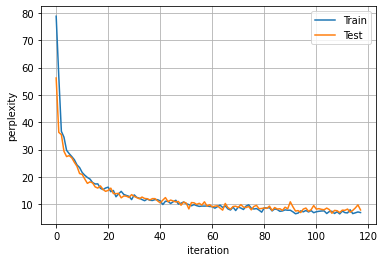

In [39]:
train_model()

# Пробуем другие варианты

Embeddings: 512 Hidden: 1024 layers: 1 lr: 0.01 batch: 64
Epoch 9... (Train/Test) Perplexity: 5.0437/7.1590


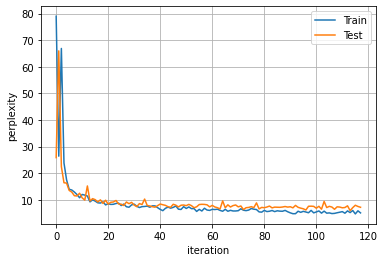

In [40]:
train_model(512, 1024, 1)

Embeddings: 64 Hidden: 512 layers: 3 lr: 0.1 batch: 64
Epoch 9... (Train/Test) Perplexity: 7.3013/8.4564


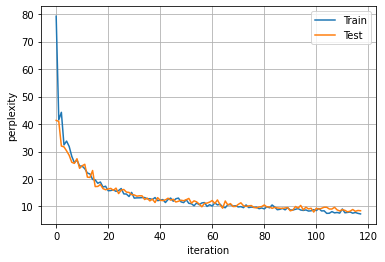

In [41]:
train_model(64, 512, 3, 0.1)

Embeddings: 400 Hidden: 800 layers: 1 lr: 0.1 batch: 128
Epoch 9... (Train/Test) Perplexity: 5.1689/6.6885


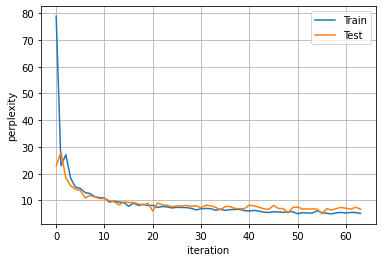

In [42]:
train_model(400, 800, 1, 0.1, 128)

Embeddings: 64 Hidden: 256 layers: 1 lr: 0.01 batch: 64
Epoch 9... (Train/Test) Perplexity: 5.6335/7.5978


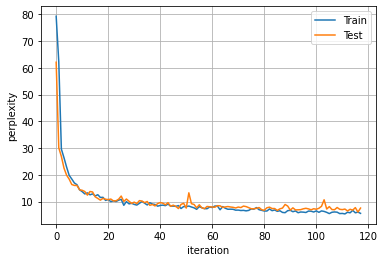

In [43]:
train_model(64, 256, 1)

Тюнинг параметров дает 6.6885 против 7.9298 при дефолтной модели (на тесте)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: